In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from tqdm import tqdm


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

import shutil

import warnings
warnings.filterwarnings("ignore")

In [3]:
BATCH_SIZE = 128
LR = 0.0001

In [5]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.RandomResizedCrop(224),         # randomly crop to 224 pixels
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # randomly adjust color
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), # apply random affine transformation
        transforms.RandomPerspective(distortion_scale=0.2), # apply random perspective transformation
        transforms.GaussianBlur(kernel_size=3), # apply Gaussian blurring
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])


In [6]:
dataset3=datasets.ImageFolder(root='/kaggle/input/flowers/flowers',transform=train_transform)
train_size = int(0.7 * len(dataset3))
val_size = int(0.1 * len(dataset3))
test_size = len(dataset3) - train_size - val_size
train_dataset3, val_dataset3, test_dataset3 = torch.utils.data.random_split(dataset3, [train_size, val_size, test_size])

In [7]:
train_dataloader3 = DataLoader(train_dataset3, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader3 = DataLoader(val_dataset3, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV2, self).__init__()
        self.features = models.mobilenet_v2(pretrained=False).features
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [9]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.features = models.vgg16(pretrained=False).features
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:
class_names=dataset3.classes
print(class_names)
print(len(class_names))

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']
16


In [12]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
model1 = ResNet18(num_classes = len(class_names)).to(device)
model2 = VGG16(num_classes = len(class_names)).to(device)
model3 = MobileNetV2(num_classes = len(class_names)).to(device)

In [14]:
# Define the loss function and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=LR)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=LR)

criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=LR)

Learning Rate : 0.01,  Epoch 1 started....
Learning Rate : 0.01,  Epoch 2 started....
Learning Rate : 0.01,  Epoch 3 started....
Learning Rate : 0.01,  Epoch 4 started....
Learning Rate : 0.01,  Epoch 5 started....
Learning rate 0.01, Testing accuracy: 34.43%
Learning Rate : 0.001,  Epoch 1 started....
Learning Rate : 0.001,  Epoch 2 started....
Learning Rate : 0.001,  Epoch 3 started....
Learning Rate : 0.001,  Epoch 4 started....
Learning Rate : 0.001,  Epoch 5 started....
Learning rate 0.001, Testing accuracy: 41.14%
Learning Rate : 0.0001,  Epoch 1 started....
Learning Rate : 0.0001,  Epoch 2 started....
Learning Rate : 0.0001,  Epoch 3 started....
Learning Rate : 0.0001,  Epoch 4 started....
Learning Rate : 0.0001,  Epoch 5 started....
Learning rate 0.0001, Testing accuracy: 43.71%
Learning Rate : 5e-05,  Epoch 1 started....
Learning Rate : 5e-05,  Epoch 2 started....
Learning Rate : 5e-05,  Epoch 3 started....
Learning Rate : 5e-05,  Epoch 4 started....
Learning Rate : 5e-05,  Ep

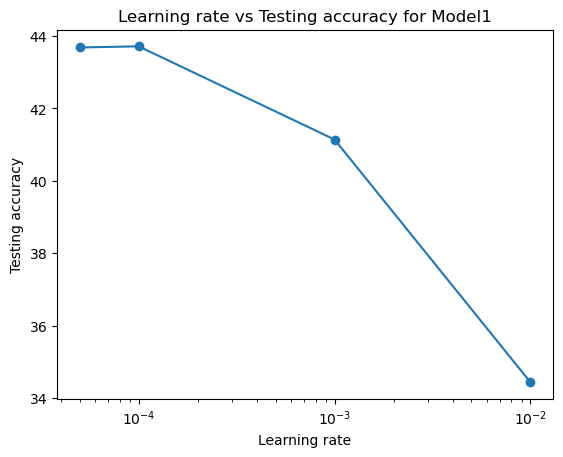

In [14]:
learning_rates = [0.01, 0.001, 0.0001, 0.00005]

test_accs = []
for lr in learning_rates:
    optimizer = optim.Adam(model1.parameters(), lr=lr)

    for epoch in range(5):
        print(f'Learning Rate : {lr},  Epoch {epoch+1} started....')
        for i, data in enumerate(train_dataloader3, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model1(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
        
    
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader3, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model1(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Learning rate {lr}, Testing accuracy: {test_acc:.2f}%')

    test_accs.append(test_acc)

plt.plot(learning_rates, test_accs, '-o')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Testing accuracy')
plt.title('Learning rate vs Testing accuracy for Model1')
plt.show()


Learning Rate : 0.01,  Epoch 1 started....
Learning Rate : 0.01,  Epoch 2 started....
Learning Rate : 0.01,  Epoch 3 started....
Learning Rate : 0.01,  Epoch 4 started....
Learning Rate : 0.01,  Epoch 5 started....
Learning Rate : 0.01,  Epoch 6 started....
Learning Rate : 0.01,  Epoch 7 started....
Learning Rate : 0.01,  Epoch 8 started....
Learning Rate : 0.01,  Epoch 9 started....
Learning Rate : 0.01,  Epoch 10 started....
Learning rate 0.01, Testing accuracy: 5.78%
Learning Rate : 0.001,  Epoch 1 started....
Learning Rate : 0.001,  Epoch 2 started....
Learning Rate : 0.001,  Epoch 3 started....
Learning Rate : 0.001,  Epoch 4 started....
Learning Rate : 0.001,  Epoch 5 started....
Learning Rate : 0.001,  Epoch 6 started....
Learning Rate : 0.001,  Epoch 7 started....
Learning Rate : 0.001,  Epoch 8 started....
Learning Rate : 0.001,  Epoch 9 started....
Learning Rate : 0.001,  Epoch 10 started....
Learning rate 0.001, Testing accuracy: 6.67%
Learning Rate : 0.0001,  Epoch 1 starte

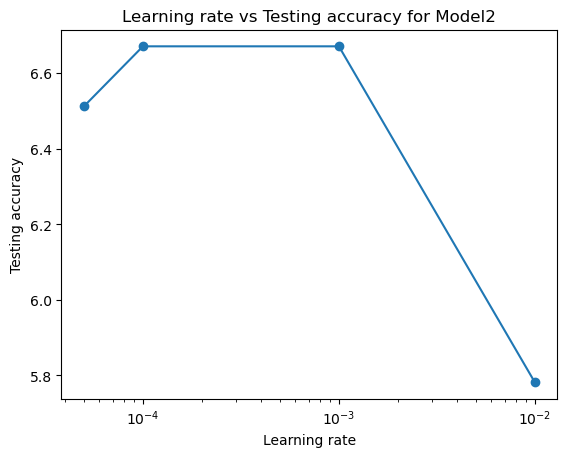

In [16]:
learning_rates = [0.01, 0.001, 0.0001, 0.00005]

test_accs = []
for lr in learning_rates:
    optimizer = optim.Adam(model2.parameters(), lr=lr)

    for epoch in range(10):
        print(f'Learning Rate : {lr},  Epoch {epoch+1} started....')
        for i, data in enumerate(train_dataloader3, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model2(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader3, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model2(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Learning rate {lr}, Testing accuracy: {test_acc:.2f}%')

    test_accs.append(test_acc)

plt.plot(learning_rates, test_accs, '-o')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Testing accuracy')
plt.title('Learning rate vs Testing accuracy for Model2')
plt.show()


Learning Rate : 0.01,  Epoch 1 started....
Learning Rate : 0.01,  Epoch 2 started....
Learning Rate : 0.01,  Epoch 3 started....
Learning Rate : 0.01,  Epoch 4 started....
Learning Rate : 0.01,  Epoch 5 started....
Learning rate 0.01, Testing accuracy: 31.16%
Learning Rate : 0.001,  Epoch 1 started....
Learning Rate : 0.001,  Epoch 2 started....
Learning Rate : 0.001,  Epoch 3 started....
Learning Rate : 0.001,  Epoch 4 started....
Learning Rate : 0.001,  Epoch 5 started....
Learning rate 0.001, Testing accuracy: 41.14%
Learning Rate : 0.0001,  Epoch 1 started....
Learning Rate : 0.0001,  Epoch 2 started....
Learning Rate : 0.0001,  Epoch 3 started....
Learning Rate : 0.0001,  Epoch 4 started....
Learning Rate : 0.0001,  Epoch 5 started....
Learning rate 0.0001, Testing accuracy: 45.11%
Learning Rate : 5e-05,  Epoch 1 started....
Learning Rate : 5e-05,  Epoch 2 started....
Learning Rate : 5e-05,  Epoch 3 started....
Learning Rate : 5e-05,  Epoch 4 started....
Learning Rate : 5e-05,  Ep

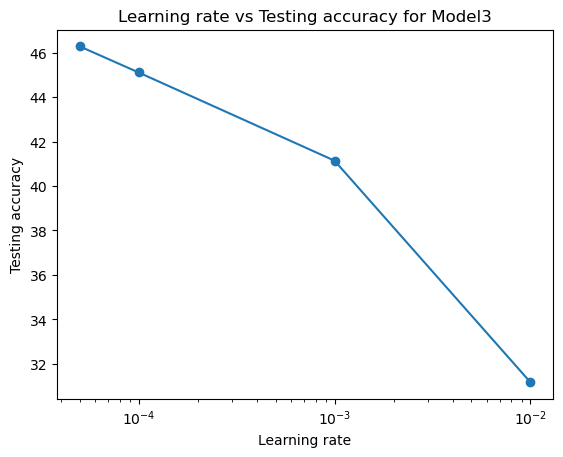

In [15]:
learning_rates = [0.01, 0.001, 0.0001, 0.00005]

test_accs = []
for lr in learning_rates:
    optimizer = optim.Adam(model3.parameters(), lr=lr)

    for epoch in range(5):
        print(f'Learning Rate : {lr},  Epoch {epoch+1} started....')
        for i, data in enumerate(train_dataloader3, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model3(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader3, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model3(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Learning rate {lr}, Testing accuracy: {test_acc:.2f}%')

    test_accs.append(test_acc)

plt.plot(learning_rates, test_accs, '-o')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Testing accuracy')
plt.title('Learning rate vs Testing accuracy for Model3')
plt.show()
